In [71]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import math

# Configure hyperparameters

In [72]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 500
image_size = (460,700)  # We'll resize input images to this size
patch_size =(64,64)  # Size of the patches to be extract from the input images
num_patches = math.ceil((image_size[0] / patch_size[0]))* math.ceil((image_size[1] / patch_size[1]))
projection_dim = 64
num_heads = 8 # 4, 8 good
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8# 8, 6
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
num_classes = 10
input_shape = (460,700, 3)

In [73]:
num_patches

88

# Loading the data

In [75]:
train_examples =np.load('feature40x.npy')
train_labels = np.load('multilabels.npy')
test_examples = np.load('testfeature40x.npy')
test_labels = np.load('testmultilabels.npy')

In [77]:
# y_train = np.load('trainsparetype.npy')
# y_test = np.load('testsparetype.npy')
# y_train = np.load('trainsparsecls.npy')
# y_test = np.load('testsparsecls.npy')

In [78]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [79]:
x_train = train_examples
y_train = train_labels
x_test = test_examples
y_test = test_labels

In [80]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (1396, 460, 700, 3) - y_train shape: (1396, 10)
x_test shape: (599, 460, 700, 3) - y_test shape: (599, 10)


In [81]:
# np.std(x_train/255.0, axis=(0,1,2))

# data augmentation

In [82]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size[0], image_size[1]),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
#         layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [83]:
# 700/128

In [84]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [85]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],
            strides=[1, self.patch_size[0], self.patch_size[1], 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 460 X 700
Patch size: 64 X 64
Patches per image: 88
Elements per patch: 12288


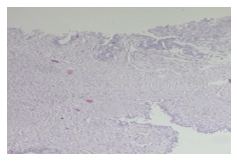

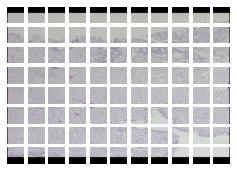

In [86]:
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size[0], image_size[1])
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size[0]} X {image_size[1]}")
print(f"Patch size: {patch_size[0]} X {patch_size[1]}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# n = math.ceil(np.sqrt(patches.shape[1]))
n=math.ceil((image_size[1] / patch_size[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size[0], patch_size[1], 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [87]:
patches.shape[1]

88

In [88]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [89]:
# def mlp(x, hidden_units, dropout_rate):
#     for units in hidden_units:
#         x = layers.Dense(units, activation=tf.nn.gelu)(x)
#         x = layers.Dropout(dropout_rate)(x)
#     return x

In [90]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [91]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
#         loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.BinaryAccuracy(name="binary_accuracy"),
#             keras.metrics.CategoricalAccuracy(name="accuracy"),
#             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),'sparse_categorical_accuracy
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_binary_accuracy",
#         monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,

        validation_split=0.1,
        shuffle=True,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    predictions = model.predict(x_test)


    return history, predictions


vit_classifier = create_vit_classifier()
history, preds = run_experiment(vit_classifier)


Epoch 1/500
79/79 [==============================] - 8s 41ms/step - loss: 0.9759 - binary_accuracy: 0.7982 - val_loss: 0.4109 - val_binary_accuracy: 0.8521
Epoch 2/500
79/79 [==============================] - 3s 34ms/step - loss: 0.4609 - binary_accuracy: 0.8442 - val_loss: 0.3129 - val_binary_accuracy: 0.8714
Epoch 3/500
79/79 [==============================] - 3s 34ms/step - loss: 0.3617 - binary_accuracy: 0.8648 - val_loss: 0.2833 - val_binary_accuracy: 0.8821
Epoch 4/500
79/79 [==============================] - 3s 32ms/step - loss: 0.3474 - binary_accuracy: 0.8663 - val_loss: 0.2837 - val_binary_accuracy: 0.8864
Epoch 5/500
79/79 [==============================] - 3s 33ms/step - loss: 0.3280 - binary_accuracy: 0.8727 - val_loss: 0.2667 - val_binary_accuracy: 0.8936
Epoch 6/500
79/79 [==============================] - 3s 32ms/step - loss: 0.3139 - binary_accuracy: 0.8815 - val_loss: 0.2581 - val_binary_accuracy: 0.8893
Epoch 7/500
79/79 [==============================] - 3s 32ms/ste

Epoch 105/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0416 - binary_accuracy: 0.9857 - val_loss: 0.0808 - val_binary_accuracy: 0.9771
Epoch 106/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0331 - binary_accuracy: 0.9852 - val_loss: 0.0937 - val_binary_accuracy: 0.9743
Epoch 107/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0310 - binary_accuracy: 0.9871 - val_loss: 0.1118 - val_binary_accuracy: 0.9607
Epoch 108/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0452 - binary_accuracy: 0.9815 - val_loss: 0.1280 - val_binary_accuracy: 0.9700
Epoch 109/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0432 - binary_accuracy: 0.9860 - val_loss: 0.1150 - val_binary_accuracy: 0.9629
Epoch 110/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0411 - binary_accuracy: 0.9834 - val_loss: 0.1154 - val_binary_accuracy: 0.9714
Epoch 111/500
79/79 [==============================]

Epoch 157/500
79/79 [==============================] - 3s 32ms/step - loss: 0.0251 - binary_accuracy: 0.9907 - val_loss: 0.0978 - val_binary_accuracy: 0.9671
Epoch 158/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0419 - binary_accuracy: 0.9833 - val_loss: 0.1353 - val_binary_accuracy: 0.9557
Epoch 159/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0262 - binary_accuracy: 0.9888 - val_loss: 0.1398 - val_binary_accuracy: 0.9629
Epoch 160/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0241 - binary_accuracy: 0.9917 - val_loss: 0.1303 - val_binary_accuracy: 0.9629
Epoch 161/500
79/79 [==============================] - 3s 35ms/step - loss: 0.0287 - binary_accuracy: 0.9890 - val_loss: 0.1113 - val_binary_accuracy: 0.9586
Epoch 162/500
79/79 [==============================] - 3s 35ms/step - loss: 0.0205 - binary_accuracy: 0.9926 - val_loss: 0.1507 - val_binary_accuracy: 0.9486
Epoch 163/500
79/79 [==============================]

Epoch 209/500
79/79 [==============================] - 3s 36ms/step - loss: 0.0293 - binary_accuracy: 0.9883 - val_loss: 0.0949 - val_binary_accuracy: 0.9700
Epoch 210/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0293 - binary_accuracy: 0.9886 - val_loss: 0.1162 - val_binary_accuracy: 0.9721
Epoch 211/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0338 - binary_accuracy: 0.9883 - val_loss: 0.0915 - val_binary_accuracy: 0.9700
Epoch 212/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0125 - binary_accuracy: 0.9939 - val_loss: 0.1053 - val_binary_accuracy: 0.9686
Epoch 213/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0181 - binary_accuracy: 0.9929 - val_loss: 0.1057 - val_binary_accuracy: 0.9721
Epoch 214/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0155 - binary_accuracy: 0.9933 - val_loss: 0.1046 - val_binary_accuracy: 0.9736
Epoch 215/500
79/79 [==============================]

Epoch 261/500
79/79 [==============================] - 3s 36ms/step - loss: 0.0250 - binary_accuracy: 0.9905 - val_loss: 0.1161 - val_binary_accuracy: 0.9679
Epoch 262/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0361 - binary_accuracy: 0.9876 - val_loss: 0.1048 - val_binary_accuracy: 0.9729
Epoch 263/500
79/79 [==============================] - 3s 32ms/step - loss: 0.0192 - binary_accuracy: 0.9922 - val_loss: 0.1051 - val_binary_accuracy: 0.9736
Epoch 264/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0160 - binary_accuracy: 0.9928 - val_loss: 0.1157 - val_binary_accuracy: 0.9636
Epoch 265/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0400 - binary_accuracy: 0.9872 - val_loss: 0.1145 - val_binary_accuracy: 0.9700
Epoch 266/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0277 - binary_accuracy: 0.9897 - val_loss: 0.1258 - val_binary_accuracy: 0.9664
Epoch 267/500
79/79 [==============================]

Epoch 313/500
79/79 [==============================] - 3s 32ms/step - loss: 0.0446 - binary_accuracy: 0.9850 - val_loss: 0.1371 - val_binary_accuracy: 0.9679
Epoch 314/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0268 - binary_accuracy: 0.9909 - val_loss: 0.1410 - val_binary_accuracy: 0.9657
Epoch 315/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0183 - binary_accuracy: 0.9913 - val_loss: 0.1042 - val_binary_accuracy: 0.9743
Epoch 316/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0259 - binary_accuracy: 0.9899 - val_loss: 0.1325 - val_binary_accuracy: 0.9729
Epoch 317/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0267 - binary_accuracy: 0.9905 - val_loss: 0.1181 - val_binary_accuracy: 0.9764
Epoch 318/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0366 - binary_accuracy: 0.9894 - val_loss: 0.1437 - val_binary_accuracy: 0.9671
Epoch 319/500
79/79 [==============================]

Epoch 365/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0223 - binary_accuracy: 0.9921 - val_loss: 0.1406 - val_binary_accuracy: 0.9600
Epoch 366/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0151 - binary_accuracy: 0.9937 - val_loss: 0.1321 - val_binary_accuracy: 0.9650
Epoch 367/500
79/79 [==============================] - 3s 36ms/step - loss: 0.0212 - binary_accuracy: 0.9910 - val_loss: 0.1110 - val_binary_accuracy: 0.9700
Epoch 368/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0263 - binary_accuracy: 0.9910 - val_loss: 0.1499 - val_binary_accuracy: 0.9614
Epoch 369/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0236 - binary_accuracy: 0.9916 - val_loss: 0.1990 - val_binary_accuracy: 0.9536
Epoch 370/500
79/79 [==============================] - 3s 35ms/step - loss: 0.0216 - binary_accuracy: 0.9903 - val_loss: 0.1074 - val_binary_accuracy: 0.9764
Epoch 371/500
79/79 [==============================]

Epoch 417/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0140 - binary_accuracy: 0.9931 - val_loss: 0.1081 - val_binary_accuracy: 0.9721
Epoch 418/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0312 - binary_accuracy: 0.9898 - val_loss: 0.1073 - val_binary_accuracy: 0.9721
Epoch 419/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0214 - binary_accuracy: 0.9930 - val_loss: 0.1276 - val_binary_accuracy: 0.9750
Epoch 420/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0153 - binary_accuracy: 0.9926 - val_loss: 0.1652 - val_binary_accuracy: 0.9571
Epoch 421/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0183 - binary_accuracy: 0.9929 - val_loss: 0.1297 - val_binary_accuracy: 0.9707
Epoch 422/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0193 - binary_accuracy: 0.9910 - val_loss: 0.1335 - val_binary_accuracy: 0.9614
Epoch 423/500
79/79 [==============================]

Epoch 469/500
79/79 [==============================] - 3s 32ms/step - loss: 0.0177 - binary_accuracy: 0.9920 - val_loss: 0.1045 - val_binary_accuracy: 0.9686
Epoch 470/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0143 - binary_accuracy: 0.9932 - val_loss: 0.1608 - val_binary_accuracy: 0.9629
Epoch 471/500
79/79 [==============================] - 3s 33ms/step - loss: 0.0244 - binary_accuracy: 0.9914 - val_loss: 0.1297 - val_binary_accuracy: 0.9643
Epoch 472/500
79/79 [==============================] - 3s 35ms/step - loss: 0.0188 - binary_accuracy: 0.9945 - val_loss: 0.1232 - val_binary_accuracy: 0.9679
Epoch 473/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0198 - binary_accuracy: 0.9904 - val_loss: 0.1357 - val_binary_accuracy: 0.9671
Epoch 474/500
79/79 [==============================] - 3s 34ms/step - loss: 0.0281 - binary_accuracy: 0.9905 - val_loss: 0.1369 - val_binary_accuracy: 0.9593
Epoch 475/500
79/79 [==============================]

In [92]:
preds =tf.nn.sigmoid(preds)

In [93]:
n_preds =preds.shape[0]
tclass = (np.equal(np.argmax(test_labels[:, :2], axis=1), np.argmax(preds[:, :2], axis=1))).astype(int)
tumor_class_acc = tclass.mean()


# ttype = (np.equal(np.argmax(test_labels, axis=1), np.argmax(preds, axis=1))).astype(int)

ttype = (np.equal(np.argmax(test_labels[:, 2:], axis=1), np.argmax(preds[:, 2:], axis=1))).astype(int)
tumor_type_acc =ttype.mean()
global_acc  =(tclass *ttype).mean()

In [94]:
print(f'Tunor type accuracy:{tumor_type_acc}')
print(f'Tunor class(benign/ malignant) accuracy:{tumor_class_acc}')
print(f'Tunor accuracy:{global_acc}')

Tunor type accuracy:0.8564273789649416
Tunor class(benign/ malignant) accuracy:0.9632721202003339
Tunor accuracy:0.8497495826377296


In [95]:
# np.argmax(test_labels[:, :2], axis=1)

In [96]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_test[:,:2], preds[:,:2])
m.result().numpy()

0.9632721

In [97]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(y_test[:,2:], preds[:,2:])
m.result().numpy()

0.8564274

In [98]:
# metric = tfa.metrics.F1Score(num_classes=2, threshold=0.5)
# metric.update_state(y_test[:,:2], preds[:,:2])
# result = metric.result()
# result.numpy()

In [99]:
m = tf.keras.metrics.AUC(num_thresholds=3)
m.update_state(y_test[:,:2], preds[:,:2])

m.result().numpy()

0.9632721

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt



def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[196   8]
 [ 14 381]]


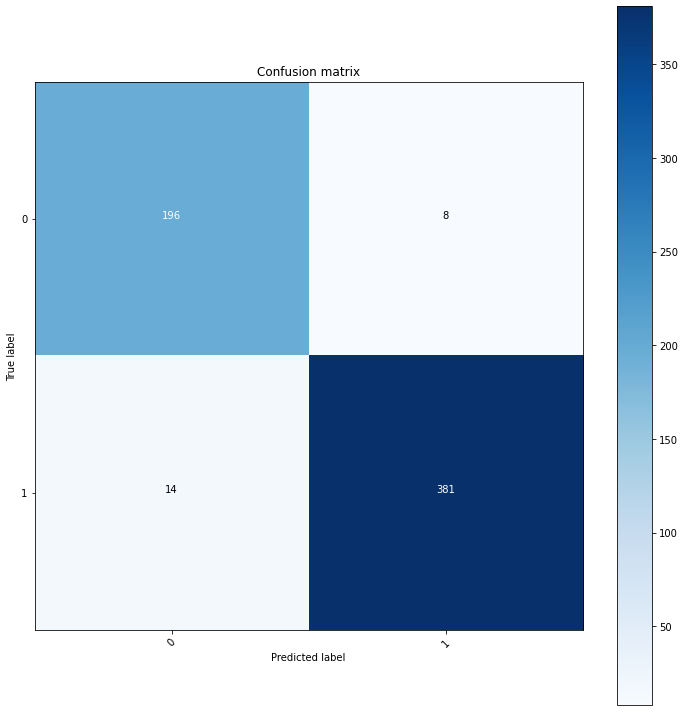

In [101]:
cm = confusion_matrix(np.argmax(test_labels[:, :2], axis=1), np.argmax(preds[:, :2], axis=1))
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, np.arange(2))

In [102]:
# print(y_test[:4,2:])

In [103]:
# preds[:4,2:]

In [104]:
# tclass = (np.equal(np.argmax(test_labels[:4, 2:], axis=1), np.argmax(preds[:4, 2:], axis=1))).astype(int)
# tumor_class_acc = tclass.mean()
# tumor_class_acc

In [105]:
# m = tf.keras.metrics.CategoricalAccuracy()
# m.update_state([[0, 0, 1], [0, 1, 0]], [[0.1, 0.9, 0.8],
#                  [0.05, 0.95, 0]])
# m.result().numpy()

In [106]:
# m.reset_states()
# m.update_state([[0, 0, 1], [0, 1, 0]], [[0.1, 0.9, 0.8],
#                  [0.05, 0.95, 0]],               sample_weight=[0.7, 0.3])
# m.result().numpy()
